In [ ]:
import pandas as pd
import numpy as np
import keras

np.random.seed(7)

In [ ]:
dest = '/content/drive/MyDrive/HSE Final Project/to_train'
name = 'submit_10_abandoned.csv'

df = pd.read_csv(dest + '/' + name)
df.shape

(10913804, 44)

In [ ]:
df['shop_id'] = df['shop_id'].astype(np.int8)
df['item_id'] = df['item_id'].astype(np.int16)
df['month'] = df['month'].astype(np.int8)
df['year'] = df['year'].astype(np.int16)
df['date_block_num'] = df['date_block_num'].astype(np.int8)
df['item_cnt'] = df['item_cnt'].astype(np.int32)
df['prev_value'] = df['prev_value'].astype(np.int32)
df['prev_value_year'] = df['prev_value_year'].astype(np.int32)
df['shop_city'] = df['shop_city'].astype(np.int8)
df['shop_category'] = df['shop_category'].astype(np.int8)
df['item_category_id'] = df['item_category_id'].astype(np.int8)
df['digital'] = df['digital'].astype(np.bool_)
df['category_type'] = df['category_type'].astype(np.int8)
df['category_subtype'] = df['category_subtype'].astype(np.int8)
df['item_cnt_lag_2'] = df['item_cnt_lag_2'].astype(np.int32)
df['item_cnt_lag_3'] = df['item_cnt_lag_3'].astype(np.int32)
df['item_cnt_lag_4'] = df['item_cnt_lag_4'].astype(np.int32)
df['item_cnt_lag_5'] = df['item_cnt_lag_5'].astype(np.int32)
df['item_cnt_lag_6'] = df['item_cnt_lag_6'].astype(np.int32)

for col in df.columns[22:40]:
    df[col] = df[col].astype(np.int32)

df.head()

,shop_id,item_id,month,year,date_block_num,item_cnt,item_price,prev_value,prev_value_year,stock_prev,stock_prev_year,shop_city,shop_category,item_category_id,digital,category_type,category_subtype,item_cnt_lag_2,item_cnt_lag_3,item_cnt_lag_4,item_cnt_lag_5,item_cnt_lag_6,cnt_block_shop_lag_1,cnt_block_shop_lag_2,cnt_block_shop_lag_3,cnt_block_shop_lag_4,cnt_block_shop_lag_5,cnt_block_shop_lag_12,cnt_block_item_lag_1,cnt_block_item_lag_2,cnt_block_item_lag_3,cnt_block_item_lag_4,cnt_block_item_lag_5,cnt_block_item_lag_12,cnt_block_category_lag_1,cnt_block_category_lag_2,cnt_block_category_lag_3,cnt_block_category_lag_4,cnt_block_category_lag_5,cnt_block_category_lag_12,date_item_avg_item_cnt,shop_item_avg_item_cnt,cat_item_avg_item_cnt,delta_price_lag
0,0,19,1,2013,0,0,0.0,0,0,0.0,0.0,29,4,40,False,7,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.02222,0.0,0.02222,-1.0
1,0,27,1,2013,0,0,0.0,0,0,0.0,0.0,29,4,19,False,5,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.15550,0.0,0.05682,-1.0
2,0,28,1,2013,0,0,0.0,0,0,0.0,0.0,29,4,30,False,5,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.17770,0.0,0.14120,-1.0
3,0,29,1,2013,0,0,0.0,0,0,0.0,0.0,29,4,23,False,5,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.08887,0.0,0.03738,-1.0
4,0,32,1,2013,0,6,221.0,0,0,0.0,0.0,29,4,40,False,7,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.64500,8.0,1.31900,-1.0


In [ ]:
dest = '/content/drive/MyDrive/HSE Final Project/to_test'
name = 'submit_10_test.csv'

test_df = pd.read_csv(dest + '/' + name)
test_df.head()

,shop_id,item_id,month,year,date_block_num,item_price,prev_value,prev_value_year,stock_prev,stock_prev_year,shop_city,shop_category,item_category_id,digital,category_type,category_subtype,item_cnt_lag_2,item_cnt_lag_3,item_cnt_lag_4,item_cnt_lag_5,item_cnt_lag_6,cnt_block_shop_lag_1,cnt_block_shop_lag_2,cnt_block_shop_lag_3,cnt_block_shop_lag_4,cnt_block_shop_lag_5,cnt_block_shop_lag_12,cnt_block_item_lag_1,cnt_block_item_lag_2,cnt_block_item_lag_3,cnt_block_item_lag_4,cnt_block_item_lag_5,cnt_block_item_lag_12,cnt_block_category_lag_1,cnt_block_category_lag_2,cnt_block_category_lag_3,cnt_block_category_lag_4,cnt_block_category_lag_5,cnt_block_category_lag_12,date_item_avg_item_cnt,shop_item_avg_item_cnt,cat_item_avg_item_cnt,delta_price_lag
0,5,5037,11,2015,34,2599.0,0,1,0.0,2599.0,3,3,19,False,5,9,1,3,1,1,1,1052,1092,1294,991,954,1445,25,110,119,54,105,65,21346,24604,23616,19872,22261,49726,0.0,0.9287,1.951,-1188.0000
1,5,5320,11,2015,34,0.0,0,0,0.0,0.0,3,3,55,False,9,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0000,0.000,0.0000
2,5,5233,11,2015,34,1199.0,1,0,1199.0,0.0,3,3,19,False,5,9,3,1,0,2,3,1052,1092,1294,991,954,0,42,80,150,37,119,0,21346,24604,23616,19872,22261,0,0.0,1.4290,1.657,6.0980
3,5,5232,11,2015,34,599.0,0,0,0.0,0.0,3,3,23,False,5,18,0,1,0,0,0,1052,1092,1294,0,0,0,28,48,65,0,0,0,21346,24604,23616,0,0,0,0.0,0.3333,1.093,0.8545
4,5,5268,11,2015,34,0.0,0,0,0.0,0.0,3,3,20,False,5,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0000,0.000,0.0000


In [ ]:
df = df[df.date_block_num >= 12]
df.reset_index(drop=True, inplace=True)
df.shape

(6425094, 44)

In [ ]:
X_train = df[df.date_block_num < 33].drop(['item_cnt'], axis=1)
y_train = df[df.date_block_num < 33]['item_cnt']
X_valid = df[df.date_block_num == 33].drop(['item_cnt'], axis=1)
y_valid = df[df.date_block_num == 33]['item_cnt']
X_test = test_df

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [ ]:
inp_size = X_train.shape[1]
inp_size

43

In [ ]:
len(X_valid)

238172

In [ ]:
len(X_test)

214200

In [ ]:
# X_train = X_train.reshape(-1, 1, 43)
# X_valid = X_valid.reshape(-1, 1, 43)
# X_test = X_test.reshape(-1, 1, 43)

# y_train = y_train.values.reshape(-1, 1)
# y_valid = y_valid.values.reshape(-1, 1)

In [ ]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

model = Sequential()

# model.add(LSTM(32,
#                input_shape=(1,inp_size,)))
# model.add(TimeDistributed(Dense(1)))
# model.add(MaxPooling1D(3))
model.add(Dense(1024, activation='relu', input_shape=(inp_size,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.25))
# model.add(Dense(56, activation='relu'))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              45056     
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 701,441
Trainable params: 701,441
Non-trai

In [ ]:
path = '/content/drive/MyDrive/HSE Final Project/Models/NN/#5.hdf5'

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

model_checkpoint_callback = ModelCheckpoint(filepath=path,
                                            save_weights_only=True,
                                            monitor='val_mae',
                                            mode='min',
                                            save_best_only=True)

model_early_stop_callback = EarlyStopping(monitor="val_loss",
                                          patience=50,
                                          verbose=1,
                                          mode="min")

In [ ]:
model.compile(optimizer='rmsprop', 
              loss='mse', 
              metrics=['mae'])

In [ ]:
history = model.fit(X_train, y_train,
                    steps_per_epoch=100,
                    epochs=500,
                    callbacks=[model_checkpoint_callback,
                               model_early_stop_callback],
                    validation_data=(X_valid, y_valid),
                    validation_steps=50)

Epoch 1/500
100/100 [==============================] - 8s 65ms/step - loss: 9.5061 - mae: 0.5152 - val_loss: 23.7243 - val_mae: 0.3091
Epoch 2/500
100/100 [==============================] - 6s 60ms/step - loss: 6.2504 - mae: 0.4576 - val_loss: 19.6660 - val_mae: 0.4346
Epoch 3/500
100/100 [==============================] - 6s 59ms/step - loss: 5.7968 - mae: 0.4421 - val_loss: 19.8960 - val_mae: 0.4118
Epoch 4/500
100/100 [==============================] - 6s 60ms/step - loss: 5.4654 - mae: 0.4344 - val_loss: 19.9825 - val_mae: 0.4169
Epoch 5/500
100/100 [==============================] - 6s 60ms/step - loss: 5.2267 - mae: 0.4178 - val_loss: 19.0976 - val_mae: 0.4315
Epoch 6/500
100/100 [==============================] - 6s 60ms/step - loss: 4.9585 - mae: 0.4012 - val_loss: 18.6191 - val_mae: 0.3339
Epoch 7/500
100/100 [==============================] - 6s 60ms/step - loss: 4.8376 - mae: 0.3946 - val_loss: 18.3757 - val_mae: 0.5035
Epoch 8/500
100/100 [==============================] - 

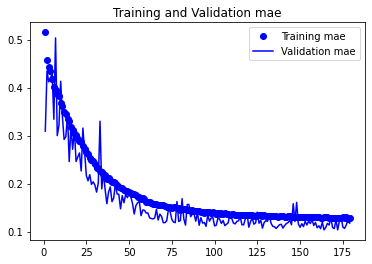

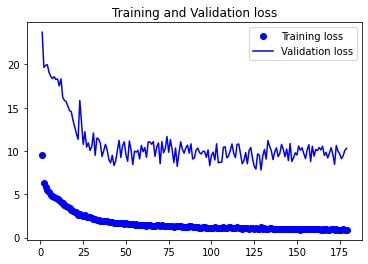

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['mae']
val_acc = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training mae')
plt.plot(epochs, val_acc, 'b', label='Validation mae')
plt.title('Training and Validation mae')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [ ]:
# y_train = y_train.reshape(-1, 1)
# y_valid = y_valid.reshape(-1, 1)

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_valid, steps=50)
y_pred_rounded = np.around(y_pred)
mse = mean_squared_error(y_valid, y_pred)
mse_rd = mean_squared_error(y_valid, y_pred_rounded)

# print('MSE: %.2f' % mse)
# print('RMSE: %.2f' % (mse ** (0.5)))

print('MSE (rounded): %.2f' % mse_rd)
print('RMSE (rounded): %.2f' % (mse_rd ** (0.5)))

MSE (rounded): 10.32
RMSE (rounded): 3.21


In [ ]:
name_sample = 'sample_submission.csv'

sample = pd.read_csv(dest + '/' + name_sample)
sample.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [ ]:
test_pred = np.around(model.predict(X_test, steps=50))
print(test_pred)

[[-11.]
 [ -0.]
 [  1.]
 ...
 [  1.]
 [ -0.]
 [  1.]]


In [ ]:
sample.item_cnt_month = test_pred
sample.head()

,ID,item_cnt_month
0,0,-11.0
1,1,-0.0
2,2,1.0
3,3,1.0
4,4,-0.0


In [ ]:
dest = '/content/drive/MyDrive/HSE Final Project/submissions/'
sample.to_csv(dest + 'nn_submission_new #3.csv', index=False)